# Задание 1 

### Сравнить МНК-оценку для линейной регрессии с методом наименьших модулей в случае, когда шум порожден из распределения Лапласа. Когда оценки совпадают, а когда сильно различаются? 

#### План решения 

Рассмотрим две модели: МНК и МНМ. 

Для того, чтобы понять, от чего зависит, совпадают оценки или различаются проварьируем следующие гиперпараметры:
 - Число признаков k
 - Число объектов в выборке n
 - Различные теоретические комбинации коэффициентов:
  -  одинаковые коэффициенты
  -  близкие по значению коэффициенты
  -  коэффициенты сильно отличающиея оп значению
 
Для сравнения моделей между собой будем рассматривать коэффициент детерминации (нормированный, т.к. есть случаи вариации количества признаков). 

Для определения влияния гиперпараметров будем рассматривать модуль разность между коэффициентами (среднее и разброс значений).

#### Подключение библиотек и определение функций

In [362]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as ss
from scipy.optimize import minimize
import numpy.random
from sklearn.linear_model import LinearRegression

###### Функции, определяющие базовые матрицы регрессии

In [363]:
#Признаки X генерируем случайным образом. Добавляем константный признак

def get_X(k, n, mu, std, seed):
    sample = ss.norm.rvs(loc=mu, scale=std, size=n, random_state=seed)
    X = np.random.rand(n, k)
    X = np.c_[X, np.ones(n)]      
    return X

In [364]:
#Считаем предполагаемый нами y_true по признакам и теоретическим коэффициентам модели

def get_y(X, A, alpha, beta):
    y = X.dot(A)
    err = ss.laplace.rvs(loc = alpha, scale = beta, size=len(y))
    return y+err

In [365]:
#Можно генерировать случайные коэффициенты, но мы этим пока что не пользуемся

def get_coeff(  k, seed, crange):
    np.random.seed(seed)
    coeff = np.random.choice(crange, size=k+1, replace=True)
    return coeff

###### Для метода наименьших модулей определим методы, считающие коэффициенты и значение целевой переменной

In [366]:
def fit_lad(X, params):
    return X.dot(params)

def cost_function(params, X, y):
    return np.sum(np.abs(y - fit_lad(X, params)))

In [367]:
#Ошибки и коэффициент детерминации для определения качества моделей

def rss(y_true, y_pred): #residual sum of squares
    return sum((y_true-y_pred)**2)
def tss(y_true): #total sum of squares
    return sum((y_true-y_true.mean())**2)
def det_coeff(rss, tss, k, n): #coefficient of determinance for comparing models with different k
    return 1-rss/tss*(n-1)/(n-k) #т.к. k_true = k+1

In [368]:
def get_info(k, n, c_range, seed, mu, std, alpha, beta):
    A = get_coeff(k, seed, c_range)
    X = get_X(k, n,  mu, std, seed)
    y = get_y(X, A, alpha, beta)    
    output = minimize(cost_function, np.ones(k+1), args=(X, y))
    reg = LinearRegression().fit(X, y)
    beta_mnk = reg.coef_
    beta_lad = output.x
    t = tss(y)
    determ_coeff_mnk = (det_coeff(rss(y, reg.predict(X)), t, k, n))
    determ_coeff_lad = (det_coeff(rss(y, fit_lad(X, beta_lad)), t, k, n))
    
    return beta_mnk, beta_lad, determ_coeff_mnk, determ_coeff_lad, A
    

#### Вычисления

In [369]:
#Вариация теоретических коэффициентов модели
coeff_ranges = [[1], [0,1],[20], [20, 21], [1, 1000], [-1000, 1000], range(20), range(200), range(2000)]

In [370]:
seed = 42
mu = 0
std = 1

In [371]:
k = 9 #features without const
n = 5000 #objects
alpha = 4
beta = 4
c_range = range(20)

In [470]:
#basic matrixes
A = get_coeff(k, seed, c_range)
X = get_X(k, n,  mu, std, seed)
y = get_y(X, A, alpha, beta)

###### Варьируем коэффициенты

In [372]:
differences_c = []
determ_mnk_c = []
determ_lad_c = []
coefficients_c = []
betas_mnk_c = []
betas_lad_c = []
for i in coeff_ranges:
    beta_mnk, beta_lad, determ_coeff_mnk, determ_coeff_lad, A = get_info(k, n, i, seed, mu, std, alpha, beta)
    coefficients_c.append(A)
    betas_lad_c.append(beta_lad)
    betas_mnk_c.append(beta_mnk)
    determ_mnk_c.append(determ_coeff_mnk)
    determ_lad_c.append(determ_coeff_lad)
    differences_c.append(abs(beta_mnk - beta_lad))

In [373]:
df_c = pd.DataFrame(differences_c)
df_c[6] = coefficients_c

###### Варьируем k

In [374]:
differences_k = []
determ_mnk_k = []
determ_lad_k = []
coefficients_k = []
betas_mnk_k = []
betas_lad_k = [] 
k_param = []
for i in range(100):
    beta_mnk, beta_lad, determ_coeff_mnk, determ_coeff_lad, A = get_info(i, n, c_range, seed, mu, std, alpha, beta)
    coefficients_k.append(A)
    betas_lad_k.append(beta_lad)
    betas_mnk_k.append(beta_mnk)
    determ_mnk_k.append(determ_coeff_mnk)
    determ_lad_k.append(determ_coeff_lad)
    differences_k.append(abs(beta_mnk - beta_lad))
    k_param.append(i)

In [375]:
df_k = pd.DataFrame(differences_k)
df_k = df_k.T

###### Варьируем n

In [376]:
differences_n = []
determ_mnk_n = []
determ_lad_n = []
coefficients_n = []
betas_mnk_n = []
betas_lad_n = [] 
n_param = []
for i in np.arange(100, 100100, 1000):
    beta_mnk, beta_lad, determ_coeff_mnk, determ_coeff_lad, A = get_info(k, i, c_range, seed, mu, std, alpha, beta)
    coefficients_k.append(A)
    betas_lad_n.append(beta_lad)
    betas_mnk_n.append(beta_mnk)
    determ_mnk_n.append(determ_coeff_mnk)
    determ_lad_n.append(determ_coeff_lad)
    differences_n.append(abs(beta_mnk - beta_lad))
    n_param.append(i)

In [377]:
df_n = pd.DataFrame(differences_n)
df_n = df_n.T

###### Варьируем $\alpha$, $\beta$ для распределения ошибок

In [378]:
differences_ab = []
determ_mnk_ab = []
determ_lad_ab = []
coefficients_ab = []
betas_mnk_ab = []
betas_lad_ab = [] 
ab_param = []
for a in np.arange(0, 100, 10):
    for b in np.arange(0, 100, 10):
        beta_mnk, beta_lad, determ_coeff_mnk, determ_coeff_lad, A = get_info(k, n, c_range, seed, mu, std, a, b)
        coefficients_k.append(A)
        betas_lad_ab.append(beta_lad)
        betas_mnk_ab.append(beta_mnk)
        determ_mnk_ab.append(determ_coeff_mnk)
        determ_lad_ab.append(determ_coeff_lad)
        differences_ab.append(abs(beta_mnk - beta_lad))
        ab_param.append([a, b])

In [379]:
df_ab = pd.DataFrame(differences_ab)
df_ab = df_ab.T

#### Анализ полученных результатов 

Сравним качество моделей для каждой из вариаций:

In [486]:
df = pd.DataFrame([ coefficients_c, list(np.round(determ_mnk_c,3)), list(np.round(determ_lad_c, 3))]).T
df.rename(columns = {0:'True coeff', 1:'R(LS)', 2:'R(LAD)'})

,True coeff,R(LS),R(LAD)
0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",0.032,0.031
1,"[0, 1, 0, 0, 0, 1, 0, 0, 0, 1]",0.002,0.001
2,"[20, 20, 20, 20, 20, 20, 20, 20, 20, 20]",0.904,0.904
3,"[20, 21, 20, 20, 20, 21, 20, 20, 20, 21]",0.904,0.904
4,"[1, 1000, 1, 1, 1, 1000, 1, 1, 1, 1000]",1,1
5,"[-1000, 1000, -1000, -1000, -1000, 1000, -1000...",1,1
6,"[6, 19, 14, 10, 7, 6, 18, 10, 10, 3]",0.783,0.783
7,"[102, 179, 92, 14, 106, 71, 188, 20, 102, 121]",0.997,0.997
8,"[1126, 1459, 860, 1294, 1130, 1095, 1724, 1044...",1,1


Можно увидеть, что вне зависимости от того, насколько велика вносимая ошибка по сравнению с истинным значением у, модели с использование МНК и МНМ имеют одинаковый коэффициент детерминации.  Таким образом, они либо одинаково хороши, либо одинаково плохи. 

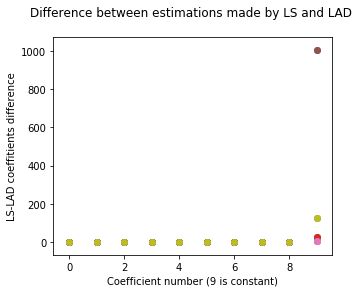

In [507]:
plt.figure(figsize = (5, 4))
for i in range(9):
    plt.scatter(range(10), abs(np.array(betas_mnk_c[i])-np.array(betas_lad_c[i])))
    plt.xlabel('Coefficient number (9 is constant)')
    plt.ylabel('LS-LAD coeffitients difference')
    plt.title('Difference between estimations made by LS and LAD \n')
plt.show()

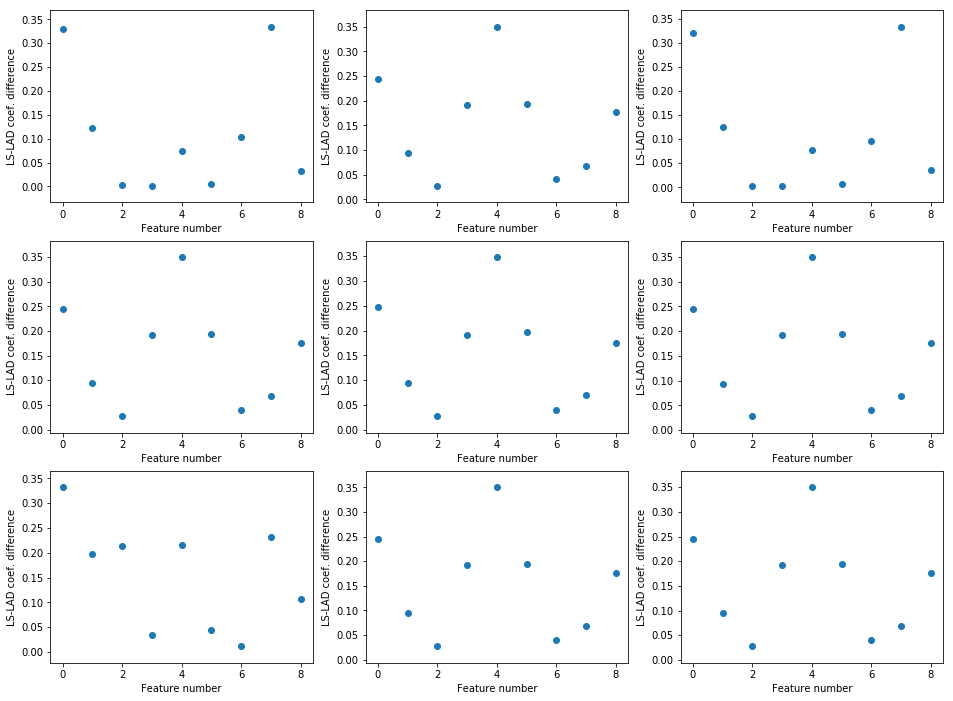

In [506]:
plt.figure(figsize = (16, 12))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.scatter(range(9), abs(np.array(betas_mnk_c[i])[:-1]-np.array(betas_lad_c[i])[:-1]))
    plt.xlabel('Feature number')
    plt.ylabel('LS-LAD coef. difference')
plt.show()

Наибольшее расхождение коэффициентов, найденных разными методами, видим на константном признаке. На остальных признаках найденные коэффициенты различаются незначительно

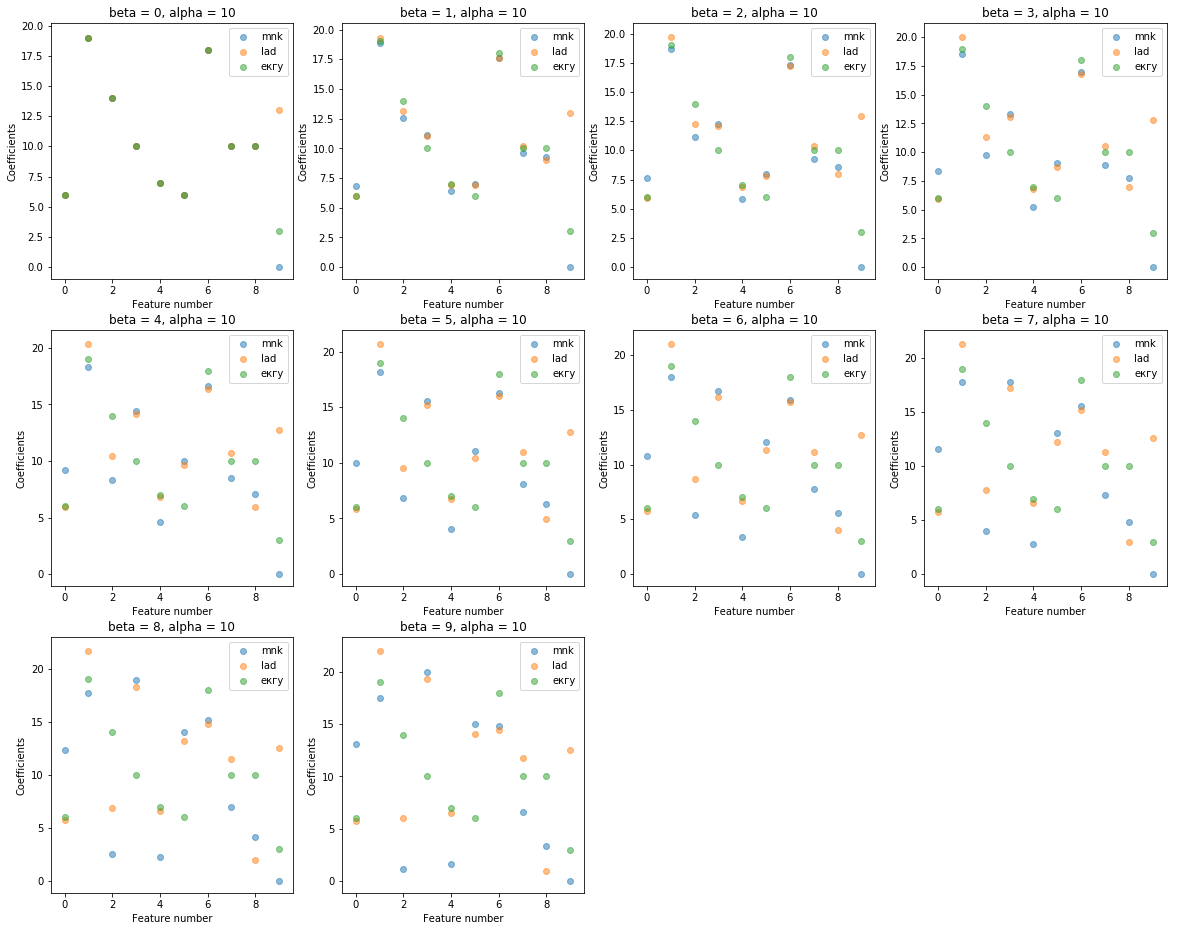

In [505]:
pd.DataFrame([ab_param, determ_mnk_ab, determ_lad_ab]).T
plt.figure(figsize = (20, 16))
for i in range(10, 20):
    ax = plt.subplot(3,4, i%10+1, title = 'beta = %i, alpha = 10' %(i%10))
    ax.scatter(np.arange(10), betas_mnk_ab[i], label = 'mnk', alpha = 0.5)
    ax.scatter(np.arange(10), betas_lad_ab[i], label = 'lad', alpha = 0.5)
    ax.scatter(np.arange(10), A, label = 'екгу', alpha = 0.5)
    ax.legend()
    ax.set_xlabel('Feature number')
    ax.set_ylabel('Coefficients')
plt.show()

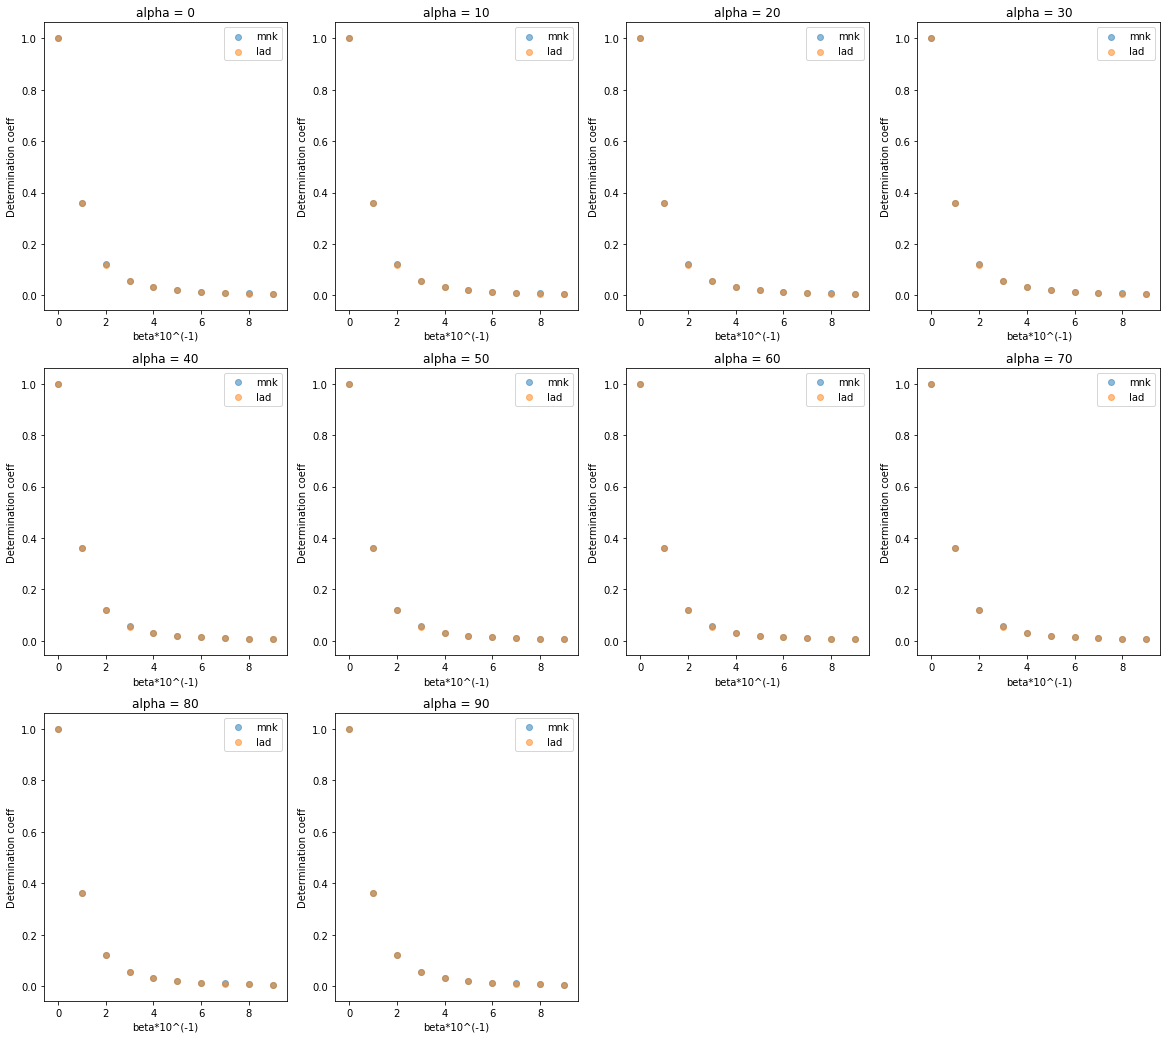

In [504]:
pd.DataFrame([ab_param, determ_mnk_ab, determ_lad_ab]).T
plt.figure(figsize = (20, 18))
for i in range(10):
    ax = plt.subplot(3,4, i+1, title = 'alpha = %i' %(i*10))
    ax.scatter(np.arange(10), determ_mnk_ab[i*10:(i+1)*10], label = 'mnk', alpha = 0.5)
    ax.scatter(np.arange(10), determ_lad_ab[i*10:(i+1)*10], label = 'lad', alpha = 0.5)
    ax.legend()
    ax.set_xlabel('beta*10^(-1)')
    ax.set_ylabel('Determination coeff')
plt.show()

Естественно заметить, что при возрастании параметра $\beta$  возрастают модули ошибок, которые мы добавляем в качестве шума. И, соответственно, ухудшается модель.

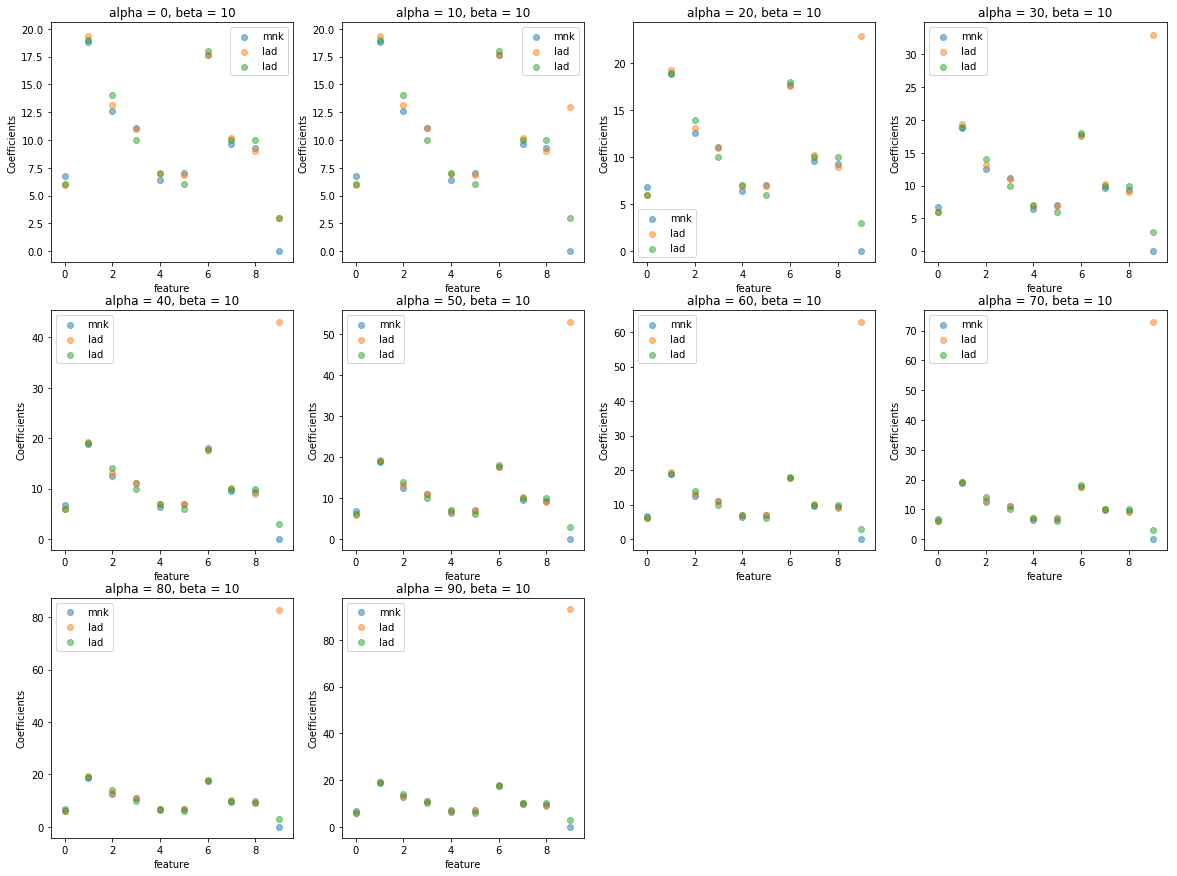

In [503]:
pd.DataFrame([ab_param, determ_mnk_ab, determ_lad_ab]).T
plt.figure(figsize = (20, 15))
for i in range(10):
    ax = plt.subplot(3,4, i+1, title = 'alpha = %i, beta = 10' %(i*10))
    ax.scatter(np.arange(10), betas_mnk_ab[i*10+1], label = 'mnk', alpha = 0.5)
    ax.scatter(np.arange(10), betas_lad_ab[i*10+1], label = 'lad', alpha = 0.5)
    ax.scatter(np.arange(10), A, label = 'lad', alpha = 0.5)
    ax.legend()
    ax.set_xlabel('feature')
    ax.set_ylabel('Coefficients')
plt.show()

Изменение параметра $\alpha$ в распределении Лапласа не влияет на разницу в оценках.

Рассмотрим среднее и стандартное отклонение для разностей между оценками МНК и МНМ.

In [462]:
flat_c = np.array([item for sublist in differences_c for item in sublist])
flat_k = np.array([item for sublist in differences_k for item in sublist])
flat_n = np.array([item for sublist in differences_n for item in sublist])
flat_ab = np.array([item for sublist in differences_ab for item in sublist])

In [385]:
print(flat_c.mean(), flat_c.std())

25.94333863757659 148.62825014953577


In [386]:
print(flat_k.mean(), flat_k.std())

0.41010182075271373 1.9520405605386284


In [387]:
print(flat_n.mean(), flat_n.std())

0.764081293810556 2.0867654551475807


In [388]:
print(flat_ab.mean(), flat_ab.std())

6.339690654697064 16.611017907269485


Можем увидеть, что параметры распределения и действительные коэффициенты вносят большую разницу в оценки. Вариация k и n не слишком влияет на различия в оценках.

Сравним оценки моделей в каждой вариации гиперпараметров:

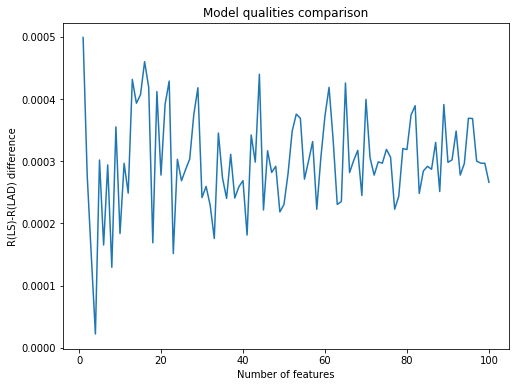

In [502]:
plt.figure(figsize = (8, 6))
plt.plot(range(1, 101), np.array(determ_mnk_k)-np.array(determ_lad_k))
plt.xlabel('Number of features')
plt.ylabel('R(LS)-R(LAD) difference')
plt.title('Model qualities comparison')
plt.show()

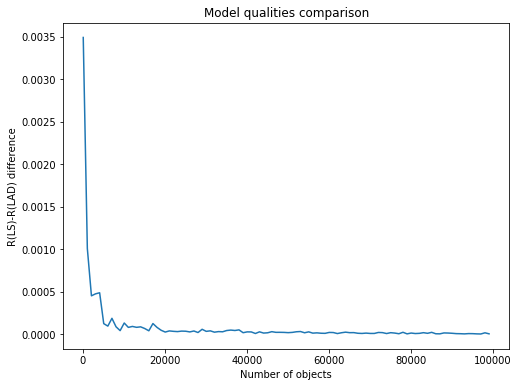

In [509]:
plt.figure(figsize = (8, 6))
plt.plot(np.arange(100, 100100, 1000), np.array(determ_mnk_n)-np.array(determ_lad_n))
plt.xlabel('Number of objects')
plt.ylabel('R(LS)-R(LAD) difference')
plt.title('Model qualities comparison')
plt.show()

Рассмотрим качество полученных моделей, рассчитав средние коэффициент детерминации и его стандартное отклонение для МНК и МНМ.

In [464]:
print(np.array(determ_mnk_c).mean(), np.array(determ_mnk_c).std(),'\n', \
      np.array(determ_lad_c).mean(),np.array(determ_mnk_c).std())

0.735715762405026 0.3901756913882442 
 0.7354559260283918 0.3901756913882442


In [467]:
print(np.array(determ_mnk_n).mean(), np.array(determ_mnk_n).std(),'\n', \
      np.array(determ_lad_n).mean(), np.array(determ_lad_n).std())

0.7733328452795657 0.0029344560812330127 
 0.773243635939648 0.002870243887041084


In [468]:
print(np.array(determ_mnk_k).mean(),np.array(determ_mnk_k).std(),'\n',\
      np.array(determ_lad_k).mean(),np.array(determ_lad_k).std())

0.8858465659639597 0.14950273525173743 
 0.8855462975399668 0.14950275544627978


In [469]:
print(np.array(determ_mnk_ab).mean(),np.array(determ_mnk_ab).std(),'\n', \
      np.array(determ_lad_ab).mean(), np.array(determ_lad_ab).std())

0.16258604293645582 0.29755388197522475 
 0.16187856325510278 0.2978052438432507


Модели существенно не отличаются.

#### Выводы 

Теоретически, метод наименьших модулей обеспечивает максимум функции правдоподобия, если ошибки измерений подчиняются закону Лапласа, а метод наименьших квадратов - когда ошибки распределены по Гауссу.

Однако можно увидеть следующее:
 - качество моделей регресси с мНК и МНМ существенно не отличается
 - чем больше число объектов, тем меньше разница между моделями и оценками коэффициентов
 - количество признаков слабо влияет на качество модели
 - наибольшая разница между МНМ и МНК оценками возникает на константном признаке